This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_004.ipynb).

# Intro tutorial 4: Plotting density of states and local density of states

We show how to use the [WESTpy Python package](http://www.west-code.org/doc/westpy/latest/) to plot the density of states and local density of states from GW quasiparticle energy levels calculated using WEST.

## Running DFT and GW calculations

We will use the negatively charged nitrogen-vacancy center in diamond as an example. Download the input and pseudopotential files to your current directory:

In [1]:
%%bash
wget -N -q http://www.west-code.org/doc/training/nv_diamond/pw.in
wget -N -q http://www.west-code.org/doc/training/nv_diamond/wstat.in
wget -N -q http://www.west-code.org/doc/training/nv_diamond/wfreq.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf

Let's inspect the ``pw.in`` file.

In [2]:
%%bash
cat pw.in

&CONTROL
  calculation = 'scf'
  wf_collect = .true.
  prefix = 'nv_diamond'
  outdir = './'
  pseudo_dir = './'
/
&SYSTEM
  ibrav = 0
  ecutwfc = 60
  nspin = 2
  tot_charge = -1
  tot_magnetization = 2.0
  nbnd = 532
  nat = 215
  ntyp = 2
/
&ELECTRONS
  diago_full_acc = .true.
/
K_POINTS gamma
CELL_PARAMETERS angstrom
10.70400  0.000000  0.000000
0.000000  10.70400  0.000000
0.000000  0.000000  10.70400
ATOMIC_SPECIES
C  12.01099968  C_ONCV_PBE-1.2.upf
N  14.00699997  N_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS crystal
C        0.000019794   0.000070305   0.000070305
C        0.083283093   0.083408574   0.083408574
C       -0.000180249   0.166803354   0.166803354
C        0.082881581   0.250195244   0.250195244
C        0.166624862  -0.000041790   0.166735686
C        0.249868283   0.083201633   0.250010134
C        0.166624862   0.166735686  -0.000041790
C        0.249868283   0.250010134   0.083201633
C       -0.000091814   0.000127381   0.333479766
C        0.083066258   0.083584948   0.

This is a relatively big system with 215 atoms and 862 valence electrons, and requires an explicit treatment of spin polarization. As detailed in [Yu et al., J. Chem. Theory Comput. 18, 4690-4707 (2022)](https://doi.org/10.1021/acs.jctc.2c00241), WEST can use GPU accelerators to carry out large-scale GW calculations. For instance, we can use four GPUs for the ground state DFT calculation, and 64 GPUs for the GW calculation.

In [ ]:
%%bash
mpirun -n 4 pw.x -i pw.in > pw.out
mpirun -n 64 wstat.x -nimage 16 -npool 2 -nbgrp 2 -i wstat.in > wstat.out
mpirun -n 64 wfreq.x -nimage 8 -npool 2 -nbgrp 4 -i wfreq.in > wfreq.out

Note that we have used the image, pool, and band group parallelization levels, as discussed in [Tutorial 3](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic_003.ipynb). By using all the parallelization levels, we avoid carrying out fast Fourier transforms (FFTs) on multiple GPUs, which is inefficient because of the all-to-all communication involved in parallel FFTs.

If the reader does NOT have the computational resources to run the calculation, the WEST output file needed for the next step can be directly downloaded as:

In [3]:
%%bash
mkdir -p nv_diamond.wfreq.save
wget -N -q http://www.west-code.org/doc/training/nv_diamond/wfreq.json -O nv_diamond.wfreq.save/wfreq.json

## Plotting density of states

The density of states (DOS) is defined as follows:
\begin{equation}
\text{DOS}(E) = \sum_{\sigma=1}^{N_{\text{spin}}} \sum_{i=1}^{N_{\text{band}}} \delta (E-E_i^{\sigma})
\end{equation}
where $E_i^{\sigma}$ is the energy of the $i$th wavefunction in the $\sigma$ spin channel obtained at the PBE or GW level of theory, and $\delta$ is the Dirac delta function. In practice, we model the delta function by a Gaussian function with a chosen width. Here we are going to use 0.1 eV.

To plot the DOS, we first collect the output of WEST into a `pandas` dataframe (see [Tutorial 1](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic_001.ipynb)).

In [4]:
# read the output of Wfreq: wfreq.json

def wfreq2df(filename='wfreq.json',dfKeys=['eks', 'eqpLin', 'eqpSec', 'sigmax', 'sigmac_eks','sigmac_eqpLin','sigmac_eqpSec', 'vxcl', 'vxcnl', 'hf']) : 

    # read data from JSON file

    import json 
    with open(filename) as file :
        data = json.load(file)
    
    import numpy as np
    import pandas as pd

    # build the dataframe
    columns = ['k', 's', 'n'] + dfKeys
    df = pd.DataFrame(columns=columns)

    # insert data into the dataframe
    j=0
    for s in range(1,data['system']['electron']['nspin']+1) :
        for k in data['system']['bzsamp']['k'] :
            kindex = f"K{k['id']+(s-1)*len(data['system']['bzsamp']['k']):06d}"
            for i, n in enumerate(data["output"]["Q"]["bandmap"]) :
                d = data['output']['Q'][kindex]
                row = [k['id'], s, n]
                for key in dfKeys :
                    if 're' in d[key] :
                        row.append(d[key]['re'][i])
                    else :
                        row.append(d[key][i])
                df.loc[j] = row
                j+=1

    # cast the columns k, s, n to int
    df['k'] = df['k'].apply(np.int64)
    df['s'] = df['s'].apply(np.int64)
    df['n'] = df['n'].apply(np.int64)
    
    return df, data

df, data = wfreq2df("nv_diamond.wfreq.save/wfreq.json")
display(df)

,k,s,n,eks,eqpLin,eqpSec,sigmax,sigmac_eks,sigmac_eqpLin,sigmac_eqpSec,vxcl,vxcnl,hf
0,1,1,321,8.367174,7.400018,7.433568,-20.102276,3.000145,3.222744,3.214358,-15.953647,0.0,-4.148628
1,1,1,322,8.367273,7.400794,7.433616,-20.101597,2.999942,3.222335,3.214098,-15.953158,0.0,-4.148439
2,1,1,323,8.376845,7.430813,7.438766,-20.127620,3.018200,3.234410,3.232714,-15.956949,0.0,-4.170671
3,1,1,324,8.377936,7.432131,7.442610,-20.138275,3.013117,3.232256,3.229776,-15.973121,0.0,-4.165155
4,1,1,325,8.381440,7.390587,7.456276,-20.008882,2.970645,3.196673,3.181567,-15.902148,0.0,-4.106734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,2,516,20.940372,22.386984,23.649553,-8.283733,-4.933001,-3.719844,-3.964094,-14.956837,0.0,6.673104
396,1,2,517,20.950590,22.336122,23.597504,-8.047657,-4.891736,-3.703635,-3.921624,-14.616189,0.0,6.568532
397,1,2,518,20.950620,22.335941,23.597143,-8.047741,-4.891770,-3.703932,-3.922213,-14.616398,0.0,6.568656
398,1,2,519,20.964816,22.421303,23.723918,-8.304636,-4.927318,-3.661473,-3.916795,-14.987825,0.0,6.683188


We create an `ElectronicStructure` object and attach to it the DFT and GW energy levels.

In [5]:
from westpy import *

es = ElectronicStructure()

dos_keys = ['eks','eqpSec']

for key in dos_keys :
    es.addKey(key,key)
    for i, row in df.iterrows() :
        k, s, n = int(row['k']), int(row['s']), int(row['n'])
        es.addDataPoint([k,s,n],key,row[key])

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.1.0
Today            :  2022-08-22 14:26:05.991251


We call the `plotDOS` method to plot the DOS.

Requested (emin,emax) :  8 20
Detected  (emin,emax) :  8.36717413576688 20.964843493350457
output written in :  dos_dft.jpg
waiting for user to close image preview...


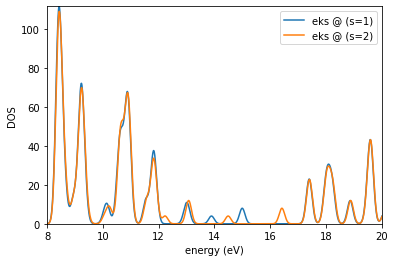

Requested (emin,emax) :  8 20
Detected  (emin,emax) :  7.433567942407069 23.951547524074822
output written in :  dos_gw.jpg
waiting for user to close image preview...


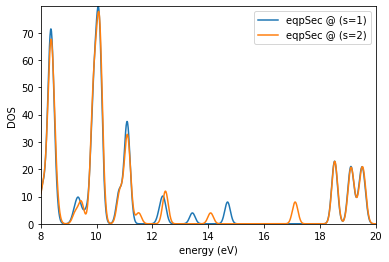

Requested (emin,emax) :  11 20
Detected  (emin,emax) :  7.433567942407069 23.951547524074822
output written in :  dos_gw2.jpg
waiting for user to close image preview...


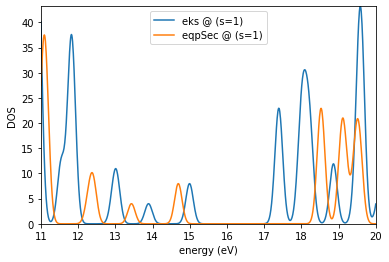

Requested (emin,emax) :  11 20
Detected  (emin,emax) :  7.437083758901655 23.93715508366057
output written in :  dos_gw3.jpg
waiting for user to close image preview...


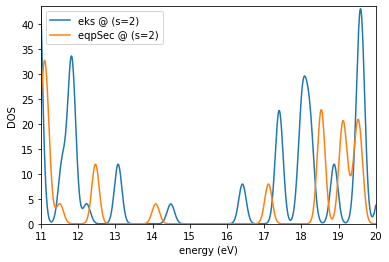

In [6]:
es.plotDOS(kk=[1],ss=[1,2],energyKeys=['eks'],energyRange=[8,20,0.01],fname='dos_dft.jpg')
es.plotDOS(kk=[1],ss=[1,2],energyKeys=['eqpSec'],energyRange=[8,20,0.01],fname='dos_gw.jpg')
es.plotDOS(kk=[1],ss=[1],energyKeys=['eks','eqpSec'],energyRange=[11,20,0.01],fname='dos_gw2.jpg')
es.plotDOS(kk=[1],ss=[2],energyKeys=['eks','eqpSec'],energyRange=[11,20,0.01],fname='dos_gw3.jpg')

## Plotting local density of states

The local density of states (LDOS) is defined as follows:
\begin{equation}
\text{LDOS}(z,E) = \sum_{\sigma=1}^{N_{\text{spin}}} \sum_{i=1}^{N_{\text{band}}} \int \frac{\text{d}x}{L_x} \int \frac{\text{d}y}{L_y} \vert \psi_i^{\sigma} (x,y,z)\vert ^2 \delta(E-E_i^{\sigma})
\end{equation}
where $\psi_i^{\sigma}$ is the $i$-th wavefunction in the $\sigma$ spin channel obtained at the PBE level of theory, with energy $E_i^{\sigma}$ obtained at the PBE or GW level of theory. $L_x$ and $L_y$ are the lengths of the x and y axes of the simulation box, respectively, whereas $z$ corresponds to the z axis of the simulation box. $\delta$ is the Dirac delta function, modeled by a Gaussian function with a width of 0.05 eV in our case.

To plot the LDOS along the z axis of the simulation box, in addition to the Kohn-Sham and quasiparticle energy levels, we need the wavefunctions averaged over z. Check out the ``westpp.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``westpp.in``.

Download this file to your current working directory:

In [7]:
%%bash
wget -N -q http://www.west-code.org/doc/training/nv_diamond/westpp.in

Let's inspect the ``westpp.in`` file, input for ``westpp.x``.

In [8]:
%%bash
cat westpp.in

input_west:
    qe_prefix: nv_diamond
    west_prefix: nv_diamond
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 862
    tr2_dfpt: 0.00000001
    n_steps_write_restart: 0

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 862
    macropol_calculation: C
    o_restart_time: -1.0
    qp_bandrange: [321,480]

westpp_control:
    westpp_calculation: W
    westpp_range: [321,480]
    westpp_format: z
    westpp_sign: False


Run ``westpp.x``.

In [ ]:
%%bash
mpirun -n 4 westpp.x -i westpp.in > westpp.out

This computes the wavefunctions averaged over the z axis, and stores the results in several ``wfcKxxxxxxBxxxxxx.plavz`` files in ``nv_diamond.westpp.save``. Again, if the reader does NOT have the computational resources to run the calculation, the output files needed for the next step can be downloaded as:

In [9]:
%%bash
wget -N -q http://www.west-code.org/doc/training/nv_diamond/nv_diamond.westpp.save.tar.gz
tar zxf nv_diamond.westpp.save.tar.gz

We create an ``ElectronicStructure`` object and register the energy levels and their associate wavefunction files. The energy levels are sorted into three categories, namely the bulk states, the spin up defect states, and the spin down defect states. States strongly localized around the nitrogen-vacancy center are considered to be the defect states. We call the ``plotLDOS`` method to plot the LDOS.

Requested (emin,emax) :  11 20
Detected  (emin,emax) :  7.433567942407069 22.976032527957337
output written in :  ldos_gw.jpg
waiting for user to close image preview...


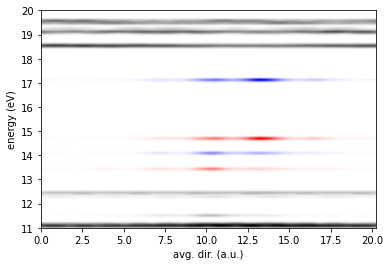

In [10]:
es2 = ElectronicStructure()

# defect states
defect_states = [430,431,432]

dos_keys = ['bulk','up','down']
for key in dos_keys :
    es2.addKey(key,key)

for i, row in df.iterrows() :
    k, s, n = int(row['k']), int(row['s']), int(row['n'])
    kindex = f"K{k+(s-1)*len(data['system']['bzsamp']['k']):06d}"
    if n in defect_states :
        if s == 1 :
            es2.addDataPoint([k,s,n],'up',row['eqpSec'])
            es2.addDataPoint([k,s,n],'wfcFile',f'nv_diamond.westpp.save/wfcK{s:06d}B{n:06d}.plavz')
        else :
            es2.addDataPoint([k,s,n],'down',row['eqpSec'])
            es2.addDataPoint([k,s,n],'wfcFile',f'nv_diamond.westpp.save/wfcK{s:06d}B{n:06d}.plavz')
    else :
        if n in range(321,481) :
            es2.addDataPoint([k,s,n],'bulk',row['eqpSec'])
            es2.addDataPoint([k,s,n],'wfcFile',f'nv_diamond.westpp.save/wfcK{s:06d}B{n:06d}.plavz')

es2.plotLDOS(kk=[1],ss=[1,2],energyKeys=['bulk','up','down'],sigma=0.05,energyRange=[11,20,0.01],fname='ldos_gw.jpg')

Where the bulk states, the spin up defect states, and the spin down defect states are plotted in black, red, and blue, respectively. The reader is encouraged to adapt the script to plot the LDOS at the PBE level of theory, and compare it to the GW result. For more information on how LDOS is computed see: [Yu et al., J. Chem. Theory Comput. 18, 4690-4707 (2022)](https://doi.org/10.1021/acs.jctc.2c00241).